# FK Weyl - tight binding model

The idea is to combine the FK interaction (annealed disorder) with some weird dispersion, in this case Weyl semimetal. The generic Hamiltonian is 
$$
H = \sum_{i,j,\alpha,\beta} c^\dagger_{i,\alpha} \hat t c_{j,\beta} + \sum_{i, \alpha} U_{i} n_{i, \alpha} w_i 
- \sum_i \mu_f w_i - \sum_{i,\alpha} \mu_c n_{i\alpha}
$$

In [24]:
import importlib
import os
import sys
def is_interactive():
    import __main__ as main
    return not hasattr(main, '__file__')
# defaults
shell_mode = not is_interactive() 
plot_graphs = importlib.util.find_spec("matplotlib") is not None and not shell_mode

In [25]:
# Matplotlib
if (plot_graphs):
    import matplotlib
    import matplotlib.pyplot as plt
    from matplotlib.ticker import AutoMinorLocator
    from matplotlib import gridspec
    import subprocess
    
    def plt_show():
        plt.show() if not shell_mode else None

    if not shell_mode:
        # Matplotlib defaults
        %matplotlib inline
        %config InlineBackend.figure_format = 'retina'
        %load_ext autoreload
        %autoreload 2

    font = {'family' : 'sans-serif', 'weight' : 'normal', 'size'   : 16}
    font2 = {'family' : 'helvetica', 'weight' : 'bold', 'size'   : 24}
    lines = {'markersize' : 0.5}
    matplotlib.rc('font', **font)
    matplotlib.rc('lines')
    matplotlib.rc('text', usetex=True)
    
    # Plot styles
    mycolors=["#083E76","#0B4D92","#2165AC","#407BB8","#368B6B","#58A588","#f4a582","#d6604d","#b2182b","#393B3D","#D13648"]
    mypts=["o","^","v","s","p","h","d","8","4"]
    mylines=["-","--",":","-.","-","--",":","-.","-"]
    myformats = [x + y for (x,y) in zip(mypts,mylines)]
    stylepick = lambda x,l : int(round((len(mycolors)-2) / float(l)*x + 1,0))
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# Parameters from command line parser
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
 
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
 
    return False
    
def args_to_params(args_in, mp):
    import argparse
    parser = argparse.ArgumentParser(description='m_proximity',formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    [parser.add_argument('--'+n, default = v) for n,v in mp.items()]
    args = parser.parse_args(args_in)
    p1 = vars(args)
    p = dict((k, type(mp[k])(v)) for k, v in p1.items() if v!=None)
    return p

In [27]:
# Output data
data_out = dict()

## TB Hamiltonian

The Weyl Hamiltonian is 
$$
\hat t = \frac{k_z^2}{2m} \sigma_z + k_x \sigma_x + k_y \sigma_y.
$$

A bit more involved version reads
$$
\hat t = v (\sin k_x \sigma_x + \sin k_y \sigma_y) + (M - t (\cos k_x + \cos k_y + \cos k_z))\sigma_z
$$
which low-k expansion is in fact 
$$
H = v (k_x \sigma_x + k_y \sigma_y ) + (M - t + t \frac{k_x^2 + k_y^2 + k_z^2}{2}) \sigma_z
$$

In [28]:
p = {
    "t" : 1, 
    "M": -1.5, 
    "v" : 1,
    
    "save_hdf5" : 1,
    "h5path" : "",
    "h5section" : "",
    "h5file" : "kwant_lattice.h5",
    }

import itertools
ns_in = [x for x in itertools.chain.from_iterable(["--"+n, str(v)] for n,v in {**p}.items())]
p=args_to_params(ns_in if not shell_mode else sys.argv[1:len(sys.argv)], p)

print("Params:\n",p)

Params:
 {'t': 1, 'M': -1.5, 'v': 1, 'save_hdf5': 1, 'h5path': '', 'h5section': '', 'h5file': 'kwant_lattice.h5'}


In [29]:
p_names = {
    "t" : "t",
    "M" : "M",
    "v" : "v",
}
fname_text = "".join(["{}{:1.3f}".format(x.replace("_",""),p[x]) for x in sorted(p_names.keys())])
print(fname_text)

M-1.500t1.000v1.000


### Kwant routines

In [30]:
import kwant
import sympy
import sympy.functions
import sympy.functions.elementary
import sympy.functions.elementary.trigonometric
import numpy as np
import tinyarray
from types import SimpleNamespace

sympy.init_printing(use_latex='mathjax')

import discretizer as dr

In [31]:
k_x, k_y, k_z = dr.momentum_operators
k = sympy.sqrt(k_x**2+k_y**2 +k_z**2)
x, y, z = dr.coordinates
sigma_x = sympy.physics.matrices.msigma(1)
sigma_y = sympy.physics.matrices.msigma(2)
sigma_z = sympy.physics.matrices.msigma(3)
sigma_0 = sigma_z * sigma_z
M,t,mu,v = sympy.symbols('M t mu v', commutative=True)

In [32]:
H1 = k_x * sigma_x + k_y * sigma_y + k_z*k_z / 2 * sigma_z - mu * sigma_z
H2 = v * (k_x * sigma_x + k_y * sigma_y)  + (M - t + t/2*k**2)*sigma_z

In [33]:
Hs = H2
#print(sympy.latex(H1))
#print(sympy.latex(H2))
Hs

⎡          ⎛  2      2      2⎞                                  ⎤
⎢        t⋅⎝kₓ  + k_y  + k_z ⎠                                  ⎥
⎢M - t + ─────────────────────           v⋅(kₓ - ⅈ⋅k_y)         ⎥
⎢                  2                                            ⎥
⎢                                                               ⎥
⎢                                ⎛          ⎛  2      2      2⎞⎞⎥
⎢                                ⎜        t⋅⎝kₓ  + k_y  + k_z ⎠⎟⎥
⎢       v⋅(kₓ + ⅈ⋅k_y)          -⎜M - t + ─────────────────────⎟⎥
⎣                                ⎝                  2          ⎠⎦

In [34]:
tb = dr.Discretizer(Hs, discrete_coordinates={'x', 'y', 'z'}, lattice_constant=1.0, verbose=False)

In [35]:
tb.symbolic_hamiltonian

⎧           ⎡        3⋅t              ⎤             ⎡-t        ⎤             ⎡
⎪(0, 0, 0): ⎢M - t + ───       0      ⎥, (0, 0, 1): ⎢────   0  ⎥, (0, 1, 0): ⎢
⎪           ⎢          2              ⎥             ⎢   2      ⎥             ⎢
⎪           ⎢         a               ⎥             ⎢2⋅a       ⎥             ⎢
⎨           ⎢                         ⎥             ⎢          ⎥             ⎢
⎪           ⎢                      3⋅t⎥             ⎢       t  ⎥             ⎢
⎪           ⎢     0       -M + t - ───⎥             ⎢ 0    ────⎥             ⎢
⎪           ⎢                        2⎥             ⎢         2⎥             ⎢
⎩           ⎣                       a ⎦             ⎣      2⋅a ⎦             ⎣

-t     v  ⎤             ⎡-t    ⅈ⋅v ⎤⎫
────  ─── ⎥, (1, 0, 0): ⎢────  ─── ⎥⎪
   2  2⋅a ⎥             ⎢   2  2⋅a ⎥⎪
2⋅a       ⎥             ⎢2⋅a       ⎥⎪
          ⎥             ⎢          ⎥⎬
-v     t  ⎥             ⎢ⅈ⋅v    t  ⎥⎪
───   ────⎥             ⎢───   ────⎥⎪
2⋅a      2⎥           

In [36]:
dims = np.array([4, 4, 4])
dims_mult = np.array([dims[1]*dims[2], dims[1], 1])

def shape(pos):
    return (0 <= pos[0] < dims[0]) and (0 <= pos[1] < dims[1]) and (0<=pos[2] < dims[2])
def lead_shape_z(pos):
    return (0 <= pos[1] < dims[1]) and (0 <= pos[0] < dims[0])
def lead_shape_x(pos):
    return (0 <= pos[1] < dims[1]) and (0 <= pos[2] < dims[2])
def lead_shape_y(pos):
    return (0 <= pos[0] < dims[0]) and (0 <= pos[2] < dims[2])


syst_in = tb.build(shape, (0, 0, 0))
lead_x = tb.build(lead_shape_x, (0, 0, 0), symmetry=(-1, 0, 0))
lead_y = tb.build(lead_shape_y, (0, 0, 0), symmetry=(0, -1, 0))
lead_z = tb.build(lead_shape_z, (0, 0, 0), symmetry=(0, 0, -1))
syst_in.attach_lead(lead_x)
syst_in.attach_lead(lead_x.reversed())
syst_in.attach_lead(lead_y)
syst_in.attach_lead(lead_y.reversed())
syst_in.attach_lead(lead_z)
syst_in.attach_lead(lead_z.reversed())


syst = syst_in.finalized()

/usr/local/lib/python3.6/site-packages/discretizer/discretizer.py:147: DeprecationWarning: 
Symmetry argument is deprecated. Please use ```periods=[symmetry]`` instead.
  DeprecationWarning)


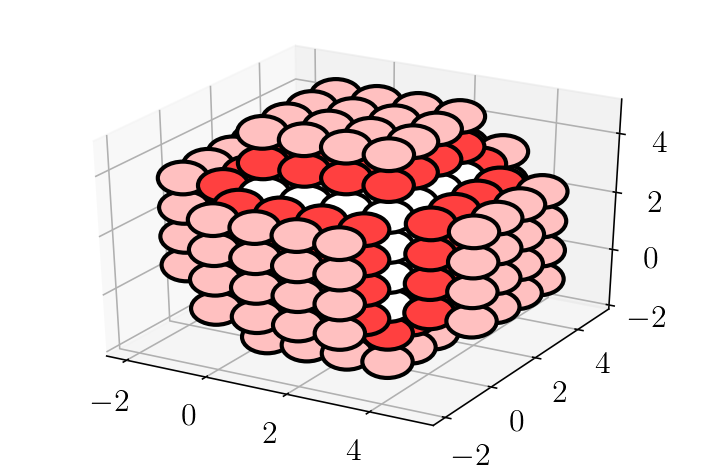

In [37]:
if plot_graphs:
    kwant.plot(syst)

### Apply parameters and extract the Hamiltonian

namespace(M=-1.5, h5file='kwant_lattice.h5', h5path='', h5section='', save_hdf5=1, t=1, v=1)


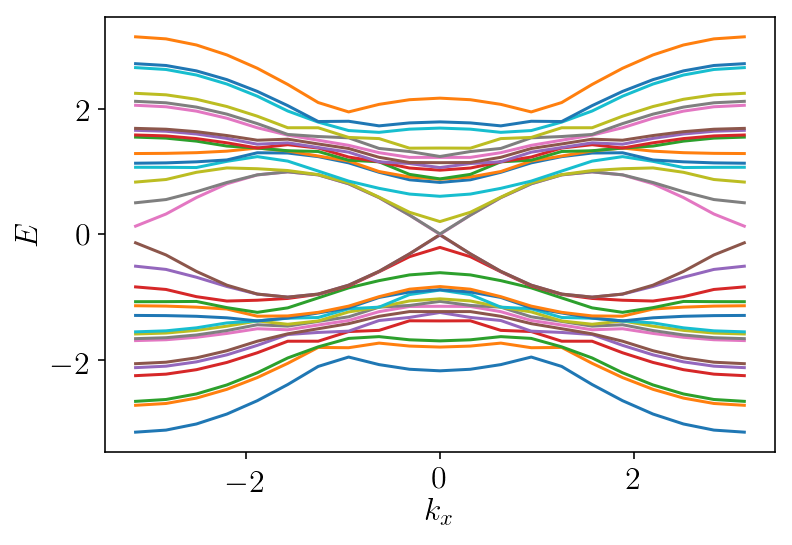

In [38]:
args = SimpleNamespace()
vars(args).update(p)
print(args)

H_Weyl = syst.hamiltonian_submatrix(args=[args], sparse=True)

if plot_graphs:
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    kwant.plotter.bands(syst.leads[0], args=[args], momenta=np.linspace(-np.pi, np.pi, 21, endpoint=True), show=False, ax = ax);
    ax.set_xlabel(r"$k_x$")
    ax.set_ylabel(r"$E$")
    plt.show()
#plt.ylim(-0.5, 0.5)

### Dump Hamiltonian ordered along the position on the lattice and the list of sites 

C++ ordering is $z-y-x$, while kwant orders as $x-y-z$
So we need to rearrange the terms in the Hamiltonian such as to get the FK-order.

In [39]:
# Order sites
orb_size = syst.hamiltonian(0,0, args).shape[0]
print("orb_size =", orb_size)

# The order of sites in kwant is not guaranteed to follow the lattice
pos_array = np.array([np.array(s.pos).astype(np.int_) for s in syst.sites])
pos_flat = np.sum(pos_array * dims_mult[::-1], axis = 1)
pos_order = np.argsort(pos_flat)
Nsites = len(pos_order)
print("Nsites =", Nsites)

#print(pos_array[pos_order])

# Convert pos_order to order of hamiltonian matrix elements
mat_order = np.column_stack(tuple([pos_order * orb_size + o for o in range(orb_size)])).flatten()

orb_size = 2
Nsites = 64


In [40]:
# Extract finite size Hamiltonian
H1 = H_Weyl.tolil()
rows,cols = H1.nonzero()
    
export_hopping = np.array([
    [row,col, H1[row,col]] for row,col in zip(rows[mat_order],cols[mat_order])
])
export_coords = pos_array[pos_order]

data_out["hopping"] = export_hopping
data_out["coordinates"] = export_coords
data_out["dims"] = dims
data_out["norbitals"] = orb_size


In [41]:
# HDF5
import h5py

def save_hdf5(h5file, h5section, name, data_out):
    write_on_top = h5section == "" or h5section == "/" or h5section == "''"
    h5mode = "a" if os.path.exists(h5file) else "w" # and not write_on_top
    #h5mode="w"
    hdf5_out = h5py.File(h5file, h5mode)

    if not write_on_top:
        if h5section in hdf5_out:
            del hdf5_out[h5section]
        h5top = hdf5_out.create_group(h5section)
    else:
        h5top = hdf5_out
    print("Saving to", h5file, "/" + h5section + "/" + name,end=": ")
    
    sg = h5top.create_group(name) 
    for h,v in data_out.items():
        print(h,end="; ")
        v1 = v
        is_complex = False
        if isinstance(v, (list, tuple, np.ndarray)):
            is_complex = (v.dtype == np.complex)
            if is_complex:
                v1 = v.astype(np.complex).view(np.float).reshape(np.append(v.shape,[2]))
        dset = sg.create_dataset(h, data = v1)
        if is_complex: 
            dset.attrs["__complex__"] = 1
    hdf5_out.close()
    print("\nDone.\n")
    
    
def read_hdf5(h5file, h5section, name):
    read_on_top = h5section == "" or h5section == "/" or h5section == "''"
    h5mode = "r" 
    success = os.path.exists(h5file)
    dummy_out = (False,None)
    if not success:
        return dummy_out

    hdf5_out = h5py.File(h5file, h5mode)
    
    success = h5section in hdf5_out or read_on_top
    if not success:
        return dummy_out

    print (h5file, h5section, name, read_on_top)
    if not read_on_top:
        h5top = hdf5_out[h5section]
    else:
        h5top = hdf5_out
    print("Reading from", h5file, "/", h5section)

    success = name in h5top
    if not success:
        return dummy_out

    
    sg = h5top[name]
    vnames = sg.keys()
    data_in1 = dict()
    for h in vnames:
        data_in1[h] = sg.get(h).value 
    hdf5_out.close()
    return (success, data_in1)

In [42]:
h5path = os.getcwd() if p["h5path"] == "" else p["h5path"]
h5file = p["h5file"]
p["h5file"] = h5file
h5file = h5path + os.path.sep + p["h5file"]
if p["save_hdf5"]:
    os.remove(h5file) if os.path.exists(h5file) else None
    save_hdf5(h5file,p["h5section"],"parameters",p) 
    save_hdf5(h5file,p["h5section"],"lattice",data_out)

Saving to /Users/antipov/code/fk_mc/kwant_lattice.h5 //parameters: t; M; v; save_hdf5; h5path; h5section; h5file; 
Done.

Saving to /Users/antipov/code/fk_mc/kwant_lattice.h5 //lattice: hopping; coordinates; dims; norbitals; 
Done.

